In [3]:
import numpy as np
import time
from matplotlib import pyplot as plt

In [29]:
def code_uniform_midrise(number,R):
    if number>=0:
        signal=1
    else:
        signal=-1
    if abs(number)>=1:
        output=2**(R-1)-1
    else:
        output=int(2**(R-1)*abs(number))
    
    return signal*output


def code_uniform_midtread(number,R):
    if number>=0:
        signal=1
    else:
        signal=-1
    if abs(number)>=1:
        output=2**(R-1)-1
    else:
        output=int( ((2**R-1)*abs(number) + 1)/2 )
    
    return signal*output

def decode_uniform_midrise(code,R):
    signal = 2*int(code&(2**(R-1))==0) - 1 
    number_abs = (abs(code)+1/2)/(2**(R-1))
    if (number_abs == 0):
        return number_abs
    else:
        return signal*number_abs

def decode_uniform_midtread(code,R):
    signal = 2*int(code&2**(R-1)==0) - 1 
    number_abs = 2*abs(code)/(2**R-1)
    return signal*number_abs

def countZeros(x,R):
     
    # Keep shifting x by one until
    # leftmost bit does not become 1.
    res=0
    if x==0:
        return R
    while ((x & (1 << (R - 1))) == 0):
        x = (x << 1)
        res += 1
 
    return res

  
def code_floating_point(number,coder,R_s,R_m):
    R = 2**(R_s) -1 + R_m
    if coder == 'midrise':
        code = code_uniform_midrise(number,R)
    elif coder == 'midtread':
        code = code_uniform_midtread(number,R)
    else:
        raise ValueError('please choose midrise or midtread as coder')
    s = int(code&(2**(R-1))!=0)
    num_zeros = countZeros(abs(code),R-1)
    if num_zeros<= 2**R_s-1:
        scale=2**R_s-1-num_zeros
    else:
        scale=0
    if scale==0:
        mantissa= s<<(R_m-1)
        mantissa+= abs(code)
    else:
        mantissa= s<<(R_m-1)
        shift = (R-num_zeros- R_m - 1)
        mask = (2**(R_m-1)-1)<< shift
        mantissa+= (mask&abs(code)) >>shift

    return scale,mantissa


def decode_floating_point(scale,mantissa,decoder,R_s,R_m):
    R = 2**(R_s) -1 + R_m
    init_shift = R - 2**R_s - 1 
    s = int(mantissa&(2**(R_m-1))!=0)
    output = 1
    output = output<<(2**R_s-1-scale) # putting zeros from scale
    total_shift = 2**R_s-1-scale

    if scale==0:
        mask = 2**(R_m-1) - 1
        output= (output<<(R_m-1)) + (mantissa&mask)
        total_shift += (R_m-1)
    else:
        output = (output<<1) + 1
        mask = 2**(R_m-1) - 1
        output= (output<<R_m-1)
        output = output + (mantissa&mask)
        total_shift += R_m
  
  
    if scale>1:
        output = (output<<1)+1
        shift = R - (len(bin(output)) -2)
        output = output<<shift
        total_shift +=shift + 1
  


    abs_out = output&(2**(total_shift)-1)
    signal = 2*int(not s) - 1


    R_bit_num = signal*abs_out

    if decoder == 'midrise':
        number = decode_uniform_midrise(R_bit_num,R)
    elif decoder == 'midtread':
        number = decode_uniform_midtread(R_bit_num,R)
    else:
        raise ValueError('please choose midrise or midtread as decoder')

    return number


In [30]:
import struct
import io

def read_wav_data_new(filename):
    with io.open(filename, 'rb') as fh:

        riff, size, fformat = struct.unpack('<4sI4s', fh.read(12))
        fmt_header = fh.read(8)
        subchunkid, subchunksize = struct.unpack('<4sI', fmt_header)
        if (subchunkid == b'fmt '):
            if (subchunksize == 16):
                fmt_data = fh.read(16)
                _, N_c, _, _, _, _ = struct.unpack("HHIIHH", fmt_data)
            elif (subchunksize == 18):
                fmt_data = fh.read(18)
                _, N_c, _, _, _, _, _ = struct.unpack("HHIIHHH", fmt_data)
            elif (subchunksize == 40):
                fmt_data = fh.read(40)
                _, N_c, _, _, _, _, _, _ = struct.unpack("HHIIHHH22s", fmt_data)
            else:
                raise ValueError('Invalid Format Chunk size (16, 18 or 40)')     
        
        chunkOffset = fh.tell()
        subchunks = []
        while (chunkOffset < size):
            fh.seek(chunkOffset)
            subchunk2id, subchunk2size = struct.unpack('<4sI', fh.read(8))
            chunk_header= struct.pack('<4sI', subchunk2id, subchunk2size)
            if (subchunk2id == b'data'):
                data_len = subchunk2size
                curr_byte=chunkOffset
                data_list=[]
                data_chunkid = subchunk2id
                data_chunk_size = subchunk2size
                while (curr_byte< subchunk2size+chunkOffset):
                    curr_byte+=2
                    byte1 = struct.unpack('<h', fh.read(2))
                    data_list.append(byte1[0]/(2**15))
            else:
                subchunk_data = fh.read(subchunk2size)
                subchunks.append((subchunk2id,subchunk2size,subchunk_data))
            chunkOffset = chunkOffset + subchunk2size + 8
            
        params = riff, size, fformat,fmt_header, fmt_data, data_chunkid, data_chunk_size, subchunks
    return params,data_list,N_c

In [31]:
def write_wav(filename,params,data):
    riff, size, fformat,fmt_header, fmt_data, data_chunkid, data_chunk_size, subchunks = params
    data_chunk_size = 2*len(data) # Each element is 2 bytes long!
    header = struct.pack('<4sI4s',riff, size, fformat)
    header+=fmt_header
    header+=fmt_data
    header+=struct.pack('<4sI', data_chunkid, data_chunk_size)
    data_string = b''
  
    for item in data:
        try:
            data_string+= struct.pack('<h',int(item*(2**15)))
        except:
            data_string+= struct.pack('<h',0)
    output=header+data_string
    for subchunk in subchunks:
        (subchunkid,subchunksize,subchunk_data) = subchunk
        output+=struct.pack('<4sI', subchunkid, subchunksize)
        output+=subchunk_data
    with open(filename,'wb') as f:
        f.write(output)


In [32]:
from bitstring import ConstBitStream
from bitstring import Bits
def bitstring_to_bytes(s):
    return int(s, 2).to_bytes((len(s) + 7) // 8, byteorder='big')


def data_list_to_array(data_list,N_c):
    data_array = np.zeros((N_c,len(data_list)//N_c))
    t = 0
    n = 0
    for data_elem in data_list:
        data_array[n,t//N_c] = data_elem
        n += 1
        n = n % N_c
        t += 1
    
    return data_array

def array_to_data_list(data_array):
    data_list = []
    n = 0
    t = 0
    
    N_c, data_len = data_array.shape
    
    while (t < data_len):
        data_list.append(data_array[n,t])
        n += 1
        n = n % N_c
        if (n == 0):
            t += 1
    
    return data_list

In [33]:
class MDCT():
    def __init__(self, N: int, window: np.ndarray):
        K = N//2
        self.n_0 = ((N/2) + 1)/2

        A = np.zeros((K,N))
        for k in range(K):
            for n in range(N):
                A[k,n] = np.cos((2*np.pi/N)*(n + self.n_0)*(k+1/2))

        self.N = N
        self.window = window

        self.A = A
        self.B = (4/N)*A.T

        if window.shape[0] != N:
            raise ValueError(f"Window is not the same size as N! Window size: {window.shape[0]}")

    def _preprocess(self, x: np.ndarray):
        L = len(x)
        self.frames = L//(self.N//2) + 1
        r = L%(self.N//2)
        extra_pad = (N//2) - r
        return np.pad(x, (self.N // 2, self.N // 2 + extra_pad))


    def mdct(self, x: np.ndarray):
        x_padded = self._preprocess(x)

        X = np.ndarray((self.A.shape[0], self.frames))
        for frame_idx in range(self.frames):
            frame = x_padded[frame_idx*(self.N//2):frame_idx*(self.N//2)+self.N]
            X[:, frame_idx] = self.A @ (frame * self.window)

        return X

    def imdct(self, X: np.ndarray):
        x_padded = np.zeros(self.frames * self.N//2 + self.N//2)
        for frame_idx in range(self.frames):
            x_padded[frame_idx*self.N//2:frame_idx*self.N//2 + self.N] += (self.B @ X[:,frame_idx]) * self.window
            
        return x_padded[self.N//2:-self.N//2]
    
    def mdct_pre_twiddle(self):
        return np.exp(-2j * np.pi * np.arange(self.N) / (2*self.N))

    def mdct_post_twiddle(self):
        return np.exp(-2j * np.pi * self.n_0 * (np.arange(self.N//2) + 0.5) / self.N)


    def mdct_via_fft(self, x):
        x_padded = self._preprocess(x)

        X = np.ndarray((self.A.shape[0], self.frames))
        for frame_idx in range(self.frames):
            frame = x_padded[frame_idx*(self.N//2):frame_idx*(self.N//2)+self.N]
            X[:, frame_idx] = np.real(
                self.mdct_post_twiddle() * np.fft.fft(frame * self.window * self.mdct_pre_twiddle())[:self.N//2]
            )
        
        return X 
    
    def imdct_pre_twiddle(self):
        return np.exp(2j * np.pi * self.n_0 * np.arange(self.N) / self.N)

    def imdct_post_twiddle(self):
        return np.exp(2j * np.pi * (np.arange(self.N) + self.n_0) / (2*self.N))
    
    def imdct_via_ifft(self, X):
        x_padded = np.zeros(self.frames * self.N//2 + self.N//2)
        for frame_idx in range(self.frames):
            x_padded[frame_idx*self.N//2:frame_idx*self.N//2 + self.N] += \
            np.real(np.fft.ifft(np.concatenate((X[:,frame_idx], -X[::-1,frame_idx])) * self.imdct_pre_twiddle()) * \
            self.imdct_post_twiddle()) * 2 * self.window
            
        return x_padded[self.N//2:-self.N//2]

In [34]:
def sine_window(N):
    M = N//2
    w = np.zeros((N,1))

    for n in range(N-M):
        w[n] = np.sin((np.pi/2)*(n+1/2)/(N-M))
        
    for n in range(N-M,M):
        w[n] = 1

    for n in range(M,N):
        w[n] = np.sin((np.pi/2)*(N - n - 1/2)/(N-M))

    return w.reshape(-1)

In [35]:
def requant_wav_file(input_wav_file, coded_filename, output_wav_file, n_bits, coder, N, window, **kwargs):
    
    ### Step 1: Read Wave File
    params,data_list,N_c = read_wav_data_new(input_wav_file)
    
    ### Step 2: MDCT
    my_MDCT = MDCT(N,window)
    
    data_array = data_list_to_array(data_list,N_c)
    
    data_MDCT_list = []
    for n in range(N_c):
        data_MDCT_list.append(my_MDCT.mdct(data_array[n,:]))
    data_MDCT = np.stack(data_MDCT_list,axis=0)
    reshape_format = data_MDCT.shape
    
    
    norm_factor = np.amax(np.abs(data_MDCT))
    data_MDCT_norm = data_MDCT/norm_factor
    
    ### Step 3: Quantisize
    coded_list = []
    if coder == 'midtread':
        for n in range(N_c):
            coded_list.append([code_uniform_midtread(x,n_bits) for x in np.nditer(data_MDCT_norm[n,:,:])])   
    elif coder == 'midrise':
        for n in range(N_c):
            coded_list.append([code_uniform_midrise(x,n_bits) for x in np.nditer(data_MDCT_norm[n,:,:])])
    elif coder == 'fp_midtread':
        R_s,R_m = kwargs['R_s'],kwargs['R_m']
        n_bits = R_s + R_m
        for n in range(N_c):
            coded_list.append([code_floating_point(x,'midtread',R_s,R_m) for x in np.nditer(data_MDCT_norm[n,:,:])])
    
    
    ### Step 4: Write Binary File
    short_bytelist = ''
    if coder =='midtread' or coder=='midrise':
        for n in range(N_c):
            for item in coded_list[n]:
                str_bits = Bits(int=item, length=n_bits).bin
                short_bytelist+=str_bits
    else:
        for n in range(N_c):
            for scale,mantissa in coded_list[n]:
                aux = scale<<R_m
                aux = aux + mantissa
                str_bits = Bits(uint=aux, length=n_bits).bin
                short_bytelist+=str_bits
    
    
    coded_data = bitstring_to_bytes(short_bytelist)
    with io.open(coded_filename, 'wb') as fh:
        fh.write(coded_data)
    

    ### Step 5: Read Binary File
    b = ConstBitStream(filename=coded_filename)

    read_data = []
    curr_bit=0
    if coder =='midtread' or coder=='midrise':
        while (curr_bit<b.length):
            code = b.read('int:{}'.format(n_bits))
            curr_bit += n_bits
            read_data.append(code)
    else:
        mask_scale = (2**R_s - 1)<<R_m
        mask_mantissa = 2**R_m-1
        while (curr_bit<b.length):
            code = b.read('uint:{}'.format(n_bits))
            scale = (code&mask_scale)>>R_m
            mask_mantissa = 2**R_m-1
            mantissa=code&mask_mantissa
            read_data.append((scale,mantissa))
            curr_bit += n_bits
    b.bitpos = b.len
    
    bytelist = []
    for item in read_data:
        if coder == 'midtread':
            x = decode_uniform_midtread(item,n_bits)
        elif coder == 'midrise':
            x = decode_uniform_midrise(item,n_bits)
        elif coder == 'fp_midtread':
            scale,mantissa = item
            x = decode_floating_point(scale,mantissa,'midtread',R_s=R_s,R_m=R_m)
         
        bytelist.append(x)
        
        
    ### Step 6: IMDCT
    MDCT_unflatten_unnorm = np.reshape(np.array(bytelist),reshape_format)
    MDCT_unflatten = MDCT_unflatten_unnorm*norm_factor
    data_IMDC_list = []                    
    for n in range(N_c):
        data_IMDC_list.append(my_MDCT.imdct(MDCT_unflatten[n,:,:]))
    data_IMDCT = np.stack(data_IMDC_list,axis=0)
    
    
    write_data = array_to_data_list(data_IMDCT)
    write_wav(output_wav_file,params,write_data)

    return data_array,data_IMDCT,data_MDCT,MDCT_unflatten
    
    

In [38]:
N = 2048
input_filename =r'samples/wav_2mb.wav'
coded_filename = r'samples/2048/wav_2mb_4_mt.bin'
output_wav_filename = r'samples/2048/wav_2mb_4_mt.wav'
window = sine_window(N)
n_bits = 4
coder = 'midtread'
data_pre_quant, data_post_quant,MDCT_pre_quant,MDCT_pos_quant = requant_wav_file(input_filename, coded_filename, output_wav_filename, n_bits, coder, N, window, R_s = 3, R_m=5)

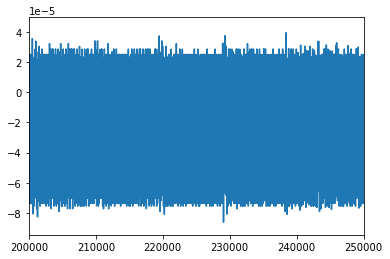

In [21]:
plt.plot(data_post_quant[0,:])
plt.plot(data_pre_quant[0,:])
plt.xlim([200000, 250000])

plt.show()

In [22]:
MDCT_pre_quant

array([[[ 0.00000000e+00,  4.78516688e-04,  1.90331959e-04, ...,
          1.66173106e+00, -3.99490515e+00,  4.67318847e-01],
        [ 0.00000000e+00,  3.38025712e-04, -3.62567297e-03, ...,
         -6.26876621e+00,  1.69965334e+00, -1.07595974e+00],
        [ 0.00000000e+00,  1.50449496e-04, -3.48420554e-03, ...,
          1.15959575e+00,  6.86814411e-01,  1.03171042e+00],
        ...,
        [ 0.00000000e+00, -6.58685846e-06, -1.14579351e-05, ...,
         -8.58762744e-05,  3.62609568e-05,  2.56584215e-04],
        [ 0.00000000e+00, -8.83509532e-06, -3.56886465e-05, ...,
          5.93285695e-05, -4.23592433e-05, -1.47431735e-04],
        [ 0.00000000e+00, -4.23294768e-06,  2.17550528e-05, ...,
          4.00645479e-05, -3.68455343e-05, -3.04014538e-04]],

       [[ 0.00000000e+00,  4.78516688e-04,  2.33820853e-04, ...,
          4.35404581e-01, -3.83854794e+00,  4.32807171e-01],
        [ 0.00000000e+00,  3.38025712e-04, -3.59321395e-03, ...,
         -5.72511637e+00, -6.44255194e

In [23]:
MDCT_pos_quant

array([[[ 8.08758160e-05,  8.08758160e-05,  8.08758160e-05, ...,
          8.08758160e-05,  8.08758160e-05,  8.08758160e-05],
        [ 8.08758160e-05,  8.08758160e-05,  8.08758160e-05, ...,
         -2.42627448e-04,  8.08758160e-05,  8.08758160e-05],
        [ 8.08758160e-05,  8.08758160e-05,  8.08758160e-05, ...,
          8.08758160e-05,  8.08758160e-05,  8.08758160e-05],
        ...,
        [ 8.08758160e-05,  8.08758160e-05,  8.08758160e-05, ...,
          8.08758160e-05,  8.08758160e-05,  8.08758160e-05],
        [ 8.08758160e-05,  8.08758160e-05,  8.08758160e-05, ...,
          8.08758160e-05,  8.08758160e-05,  8.08758160e-05],
        [ 8.08758160e-05,  8.08758160e-05,  8.08758160e-05, ...,
          8.08758160e-05,  8.08758160e-05,  8.08758160e-05]],

       [[ 8.08758160e-05,  8.08758160e-05,  8.08758160e-05, ...,
          8.08758160e-05,  8.08758160e-05,  8.08758160e-05],
        [ 8.08758160e-05,  8.08758160e-05,  8.08758160e-05, ...,
         -2.42627448e-04,  8.08758160e